# Placebo set

## Convert parquet to csv

In [5]:
import os
import pandas as pd

# Input and output directories
input_dir = '../datasets/Address_old_pins/Address_old_pins'
output_dir = '../datasets/Address_old_pins/Address_old_pins'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through all parquet files and convert to csv
for file in os.listdir(input_dir):
    if file.endswith('.parquet'):
        parquet_path = os.path.join(input_dir, file)
        csv_path = os.path.join(output_dir, file.replace('.parquet', '.csv'))
        
        # Read and save
        df = pd.read_parquet(parquet_path)
        df.to_csv(csv_path, index=False)
        print(f"Converted {file} → {os.path.basename(csv_path)}")



Converted part-00000-9a03d2e6-a352-4188-8edc-67b5c0295e13-c000.snappy.parquet → part-00000-9a03d2e6-a352-4188-8edc-67b5c0295e13-c000.snappy.csv
Converted part-00000-4e5ce549-d62a-479b-9d8f-64136e254743-c000.snappy.parquet → part-00000-4e5ce549-d62a-479b-9d8f-64136e254743-c000.snappy.csv
Converted part-00000-6f68de78-5fb8-468d-96a5-a040645440c8-c000.snappy.parquet → part-00000-6f68de78-5fb8-468d-96a5-a040645440c8-c000.snappy.csv
Converted part-00000-19ba3276-aea6-42de-87e1-038bd00cc49c-c000.snappy.parquet → part-00000-19ba3276-aea6-42de-87e1-038bd00cc49c-c000.snappy.csv


# Load and select data

## Placebo data

In [37]:
import pandas as pd
m11 = pd.read_csv('../datasets/Address_old_pins/Address_old_pins/part-00000-9a03d2e6-a352-4188-8edc-67b5c0295e13-c000.snappy.csv')
m2 = pd.read_csv('../datasets/Address_old_pins/Address_old_pins/part-00000-4e5ce549-d62a-479b-9d8f-64136e254743-c000.snappy.csv')
m8 = pd.read_csv('../datasets/Address_old_pins/Address_old_pins/part-00000-6f68de78-5fb8-468d-96a5-a040645440c8-c000.snappy.csv')
m5 = pd.read_csv('../datasets/Address_old_pins/Address_old_pins/part-00000-19ba3276-aea6-42de-87e1-038bd00cc49c-c000.snappy.csv')

### Create quarter column

In [38]:
# List of dataframes and their corresponding quarters
dfs_with_quarters = [(m11, 11), (m2, 2), (m8, 8), (m5, 5)]

# Assign fixed quarter values
for df, q in dfs_with_quarters:
    df['quarter'] = q



### Clean horizontal accuracy

In [39]:
# Overwrite each dataframe with the filtered version
dfs_with_names = [("m11", m11), ("m2", m2), ("m8", m8), ("m5", m5)]

for name, df in dfs_with_names:
    initial_row_count = len(df)

    # Filter and overwrite
    filtered_df = df[df['horizontal_accuracy'] <= 50]
    globals()[name] = filtered_df  # overwrite in global scope

    clean_row_count = len(filtered_df)
    percentage_removed = ((initial_row_count - clean_row_count) / initial_row_count) * 100
    unique_mobiles_left = filtered_df['caid'].nunique()

    print(f"=== {name} ===")
    print(f"Initial dataset size: {initial_row_count}")
    print(f"Filtered dataset size: {clean_row_count}")
    print(f"Percentage of rows removed: {percentage_removed:.2f}%")
    print(f"Number of unique mobiles left: {unique_mobiles_left}\n")



=== m11 ===
Initial dataset size: 16405754
Filtered dataset size: 15235440
Percentage of rows removed: 7.13%
Number of unique mobiles left: 25101

=== m2 ===
Initial dataset size: 24662074
Filtered dataset size: 23319557
Percentage of rows removed: 5.44%
Number of unique mobiles left: 25119

=== m8 ===
Initial dataset size: 19555239
Filtered dataset size: 18209405
Percentage of rows removed: 6.88%
Number of unique mobiles left: 25104

=== m5 ===
Initial dataset size: 19926440
Filtered dataset size: 18508331
Percentage of rows removed: 7.12%
Number of unique mobiles left: 25113



### Stack all 4 datasets

In [40]:
# Stack them into one dataframe
df_all = pd.concat([m2, m5, m8, m11], ignore_index=True)

# Quick check
print(df_all['quarter'].value_counts())
print(df_all.shape)

quarter
2     23319557
5     18508331
8     18209405
11    15235440
Name: count, dtype: int64
(75272733, 11)


## Eviction data

In [41]:
eviction_data = pd.read_csv("../datasets/clean_mega_data.csv")
eviction_data["caid"].nunique()



9503

### Get pings count per quarter for each mobile



In [42]:
# Step 1: Aggregate ping counts per mobile and quarter
def compute_ping_distribution(df):
    return (
        df.groupby(['caid', 'quarter'])
          .size()
          .unstack(fill_value=0)
          .rename(columns=lambda x: f'q{x}_pings')
    )

df1_pings = compute_ping_distribution(eviction_data)
df2_pings = compute_ping_distribution(df_all)

# Step 2: Ensure all quarters exist
for q in [2, 5, 8, 11]:
    col = f'q{q}_pings'
    df1_pings[col] = df1_pings.get(col, 0)
    df2_pings[col] = df2_pings.get(col, 0)

# Step 3: Align column order
df1_pings = df1_pings[[f'q{q}_pings' for q in [2, 5, 8, 11]]]
df2_pings = df2_pings[[f'q{q}_pings' for q in [2, 5, 8, 11]]]

### Run Hungarian method (KNN could be used but it's a greedy algorithm so mobiles at the end will have a bad matching)

In [43]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np

# Step 1: Compute full cost (distance) matrix
cost_matrix = cdist(df1_pings.values, df2_pings.values, metric='euclidean')  # shape: (9503, N)

# Step 2: Apply Hungarian algorithm to get optimal 1-to-1 matches
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Step 3: Get the matched eviction → df2 pairs
matched_eviction_ids = df1_pings.index[row_ind]
matched_df2_ids = df2_pings.index[col_ind]




### Show results

In [44]:
# Start with the eviction side
comparison_df = df1_pings.copy()

# Get the matched ping data and caid from df2
df2_matched = df2_pings.loc[matched_df2_ids].copy()
df2_matched['caid_matched'] = df2_matched.index  # matched caid (from df2)
df2_matched.index = matched_eviction_ids         # align index to eviction caids

# Reorder so caid_matched comes before ping columns
cols = ['caid_matched'] + [col for col in df2_matched.columns if col != 'caid_matched']
df2_matched = df2_matched[cols]

# Merge both sides
final_df = pd.concat([comparison_df, df2_matched], axis=1).reset_index(names='caid')

# Preview
final_df.head()



quarter,caid,q2_pings,q5_pings,q8_pings,q11_pings,caid_matched,q2_pings,q5_pings,q8_pings,q11_pings
0,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,48,112,165,127,7bad8e15970bf1459a60258b237cd9b2d14ce8dc5bc64c...,38,119,169,130
1,000c95192187099854c0562841a02cf1185e5dfffd4f6a...,58,69,180,13,07ba98ae1a07eb329c66b30581f5342ae888c7e999d614...,60,56,161,19
2,0017dae165cbe429683cadd49cf3daa8f7b086307481b6...,138,92,50,104,66faeb4f2354e4b2d9f6aa79ff00fa47c9e914861c2198...,135,90,56,105
3,0017fd86fc187c38a3234692832b3ead918bcc91b8e8ca...,48,75,245,80,c73c3ea1c607abc9008c0822ddfd5ab7ff8ce669b45cfa...,46,71,236,70
4,001c7131fdba42373b7de1c7c425f2fe0d7dec70346158...,182,235,28,163,001c7131fdba42373b7de1c7c425f2fe0d7dec70346158...,182,235,28,163


# Clustering

## Filter eviction data on matched caids

In [30]:
# Get matched caids from the larger dataset (df2)
matched_df2_caids = final_df['caid_matched'].unique()

# Filter df_all (the large dataset) to only keep those matched caids
df_all_matched = df_all[df_all['caid'].isin(matched_df2_caids)].copy()

# Check result
print(f"Original df_all rows: {len(df_all)}")
print(f"Filtered df_all rows: {len(df_all_matched)}")
print(f"Number of unique mobiles: {df_all_matched['caid'].nunique()}")



Original df_all rows: 75272733
Filtered df_all rows: 10351667
Number of unique mobiles: 9503


In [31]:
df_all_matched.head()

,caid,utc_timestamp,latitude,longitude,horizontal_accuracy,region,zipcode,ping_near_replicate_matches,csv_index,unique_days_device_shows_up,quarter
92,4838e0ff0d2f732568a8c83a22d32753d2e32d9fcd32c1...,2024-02-24 12:14:37,34.05898,-118.36334,13.0,california,90036.0,1,13899,3,2
93,4838e0ff0d2f732568a8c83a22d32753d2e32d9fcd32c1...,2024-02-24 12:14:37,34.05898,-118.36334,13.0,california,90036.0,1,13900,3,2
94,4838e0ff0d2f732568a8c83a22d32753d2e32d9fcd32c1...,2024-02-24 12:14:37,34.05898,-118.36334,13.0,california,90036.0,1,13901,3,2
118,d1fbe676c99f2194a87aed81e82871cd136b17d54f480e...,2024-02-24 02:30:35,34.15583,-118.39237,9.0,california,91607.0,1,9670,4,2
123,4838e0ff0d2f732568a8c83a22d32753d2e32d9fcd32c1...,2024-02-24 02:51:45,34.07616,-118.34431,5.0,california,90036.0,1,13899,3,2


In [32]:
# Free some RAM
del(df_all)
del(eviction_data)
del(m2)
del(m5)
del(m8)
del(m11)
del(df1_pings)
del(df2_pings)

In [35]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from tqdm import tqdm  # Progress bar

# Assuming clean_mega_data is already loaded
results = []

# DBSCAN parameters
eps = 50 / 111000  # 50 meters converted to degrees

# Loop through each unique CAID
for caid in tqdm(df_all_matched['caid'].unique(), desc="Processing CAIDs"):
    data_filtered = df_all_matched[df_all_matched['caid'] == caid].reset_index(drop=True)

    if data_filtered.empty:
        continue

    # Extract coordinates
    coords = data_filtered[['latitude', 'longitude']].values.astype(np.float32)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=1).fit(coords)
    data_filtered['cluster'] = dbscan.labels_

    # Calculate centroids
    centroid_dict = data_filtered.groupby('cluster')[['latitude', 'longitude']].mean().to_dict('index')

    # Add centroid addresses to data
    data_filtered['centroid_address'] = data_filtered['cluster'].map(centroid_dict)

    results.append(data_filtered)

# Combine results into one DataFrame
final_data = pd.concat(results).reset_index(drop=True)

# Save to CSV
final_data.to_csv('clustered_data_placebo.csv', index=False)

Processing CAIDs: 100%|██████████| 9503/9503 [1:01:33<00:00,  2.57it/s]


# Create hour column and period columns (day, evening, night)

In [36]:
import pandas as pd
import numpy as np
from datetime import datetime

# Convert timestamps to datetime using a flexible approach
final_data['datetime'] = pd.to_datetime(final_data['utc_timestamp'], format='mixed')

# Add time period indicators
def time_period(timestamp):
    hour = timestamp.hour
    if 8 <= hour < 20:
        return 'day'
    elif 20 <= hour < 24:
        return 'evening'
    else:  # 12 AM to 8 AM
        return 'night'

final_data['time_period'] = final_data['datetime'].apply(time_period)

# Create indicator columns for each period
final_data['is_day'] = (final_data['time_period'] == 'day').astype(int)
final_data['is_evening'] = (final_data['time_period'] == 'evening').astype(int)
final_data['is_night'] = (final_data['time_period'] == 'night').astype(int)

# Add date column for consistency score
final_data['date'] = final_data['datetime'].dt.date
# Make sure date column is datetime type
final_data['date'] = pd.to_datetime(final_data['date'])
# Drop the original 'time_period' column
final_data.drop('time_period', axis=1, inplace=True)

# Extract hour from datetime
final_data['hour'] = final_data['datetime'].dt.hour

In [37]:
final_data.head()

,caid,utc_timestamp,latitude,longitude,horizontal_accuracy,region,zipcode,ping_near_replicate_matches,csv_index,unique_days_device_shows_up,quarter,cluster,centroid_address,datetime,is_day,is_evening,is_night,date,hour
0,4838e0ff0d2f732568a8c83a22d32753d2e32d9fcd32c1...,2024-02-24 12:14:37,34.05898,-118.36334,13.0,california,90036.0,1,13899,3,2,0,"{'latitude': 34.05899521111111, 'longitude': -...",2024-02-24 12:14:37,1,0,0,2024-02-24,12
1,4838e0ff0d2f732568a8c83a22d32753d2e32d9fcd32c1...,2024-02-24 12:14:37,34.05898,-118.36334,13.0,california,90036.0,1,13900,3,2,0,"{'latitude': 34.05899521111111, 'longitude': -...",2024-02-24 12:14:37,1,0,0,2024-02-24,12
2,4838e0ff0d2f732568a8c83a22d32753d2e32d9fcd32c1...,2024-02-24 12:14:37,34.05898,-118.36334,13.0,california,90036.0,1,13901,3,2,0,"{'latitude': 34.05899521111111, 'longitude': -...",2024-02-24 12:14:37,1,0,0,2024-02-24,12
3,4838e0ff0d2f732568a8c83a22d32753d2e32d9fcd32c1...,2024-02-24 02:51:45,34.07616,-118.34431,5.0,california,90036.0,1,13899,3,2,1,"{'latitude': 34.07614138461539, 'longitude': -...",2024-02-24 02:51:45,0,0,1,2024-02-24,2
4,4838e0ff0d2f732568a8c83a22d32753d2e32d9fcd32c1...,2024-02-24 02:51:45,34.07616,-118.34431,5.0,california,90036.0,1,13900,3,2,1,"{'latitude': 34.07614138461539, 'longitude': -...",2024-02-24 02:51:45,0,0,1,2024-02-24,2


In [38]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import entropy
import time

def compute_bounded_streaks_with_silence(df, target_cluster):
    df = df.copy()
    df["hour_ts"] = df["datetime"].dt.floor("h")
    df = df.sort_values("hour_ts")

    cluster_hours = df[df["cluster"] == target_cluster]["hour_ts"].sort_values().to_list()
    hour_cluster_map = df.groupby("hour_ts")["cluster"].apply(set).to_dict()
    timeline = pd.date_range(df["hour_ts"].min(), df["hour_ts"].max(), freq="h")

    max_streak = 0
    current_start = None

    for hour in timeline:
        clusters = hour_cluster_map.get(hour, set())

        if not clusters:
            continue

        if clusters == {target_cluster}:
            if current_start is None:
                current_start = hour
        else:
            if current_start is not None:
                end_hour = max([h for h in cluster_hours if current_start <= h < hour], default=current_start)
                streak = int((end_hour - current_start) / pd.Timedelta(hours=1)) + 1
                max_streak = max(max_streak, streak)
                current_start = None

    if current_start is not None:
        end_hour = max([h for h in cluster_hours if h >= current_start])
        streak = int((end_hour - current_start) / pd.Timedelta(hours=1)) + 1
        max_streak = max(max_streak, streak)

    return max_streak

def compute_cluster_quarterly_metrics_vectorized_with_progress(final_data):
    df = final_data.copy()
    df["hour_ts"] = df["datetime"].dt.floor("h")

    print("🧱 [1/8] Computing corrected max streaks...")
    start = time.time()
    streak_results = []
    for (caid, quarter), group in tqdm(df.groupby(["caid", "quarter"]), desc="→ CAID/Quarter"):
        for cluster in group["cluster"].unique():
            max_streak = compute_bounded_streaks_with_silence(group, cluster)
            streak_results.append({
                "caid": caid,
                "quarter": quarter,
                "cluster": cluster,
                "max_consecutive_hours": max_streak
            })
    max_streaks = pd.DataFrame(streak_results)
    print(f"✅ Done in {time.time() - start:.2f}s")

    print("🧱 [2/8] Group-level aggregates...")
    base = df.groupby(['caid', 'quarter', 'cluster']).agg(
        total_pings=("datetime", "count"),
        unique_days=("date", "nunique"),
        unique_hours=("hour", "nunique"),
        zipcode=("zipcode", "first"),
        centroid_data=("centroid_address", "first"),
    ).reset_index()

    def extract_coord(d, key):
        try:
            d = eval(d) if isinstance(d, str) else d
            return d.get(key, np.nan)
        except:
            return np.nan

    base["centroid_latitude"] = base["centroid_data"].apply(lambda d: extract_coord(d, "latitude"))
    base["centroid_longitude"] = base["centroid_data"].apply(lambda d: extract_coord(d, "longitude"))
    base.drop(columns=["centroid_data"], inplace=True)

    print("🧱 [3/8] Log pings + general consistency...")
    base["log_total_pings"] = np.log1p(base["total_pings"])
    total_days = df.groupby(['caid', 'quarter'])['date'].nunique().rename("total_full_days_in_quarter").reset_index()
    base = base.merge(total_days, on=["caid", "quarter"], how="left")
    base["consistency_score"] = base["unique_days"] / base["total_full_days_in_quarter"]
    base.loc[base["total_full_days_in_quarter"].isna() | (base["total_full_days_in_quarter"] == 0), "consistency_score"] = np.nan

    print("🧱 [4/8] Time window consistency...")
    for period in ['day', 'evening', 'night']:
        is_period = f"is_{period}"
        period_days_col = f"total_{period}s_in_quarter"
        cluster_days_col = f"cluster_{period}_days"
        score_col = f"{period}_consistency_score"

        # Total period days per caid/quarter
        total_days = (
            df[df[is_period] == 1]
            .groupby(['caid', 'quarter'])['date']
            .nunique()
            .rename(period_days_col)
            .reset_index()
        )

        cluster_days = (
            df[df[is_period] == 1]
            .groupby(['caid', 'quarter', 'cluster'])['date']
            .nunique()
            .rename(cluster_days_col)
            .reset_index()
        )

        base = base.merge(total_days, on=["caid", "quarter"], how="left")
        base = base.merge(cluster_days, on=["caid", "quarter", "cluster"], how="left")

        # Fill NaN cluster days with 0
        base[cluster_days_col] = base[cluster_days_col].fillna(0)

        base[score_col] = base[cluster_days_col] / base[period_days_col]

        # Force NaN for all clusters if no opportunity
        base.loc[(base[period_days_col].isna()) | (base[period_days_col] == 0), score_col] = np.nan

    print("🧱 [5/8] Time window coverage...")
    flags = df.groupby(["caid", "quarter", "cluster"])[["is_day", "is_evening", "is_night"]].sum().gt(0).astype(int)
    flags["time_window_coverage"] = flags[["is_day", "is_evening", "is_night"]].sum(axis=1) / 3
    flags = flags[["time_window_coverage"]].reset_index()
    base = base.merge(flags, on=["caid", "quarter", "cluster"], how="left")

    print("🧱 [6/8] Weekend focus + dominance...")
    df["weekday"] = df["date"].dt.dayofweek

    weekend_total = df[df["weekday"] >= 5].groupby(["caid", "quarter"])["date"].nunique().rename("total_weekend_days").reset_index()
    weekday_total = df[df["weekday"] < 5].groupby(["caid", "quarter"])["date"].nunique().rename("total_weekday_days").reset_index()
    cluster_weekend = df[df["weekday"] >= 5].groupby(["caid", "quarter", "cluster"])["date"].nunique().rename("weekend_days").reset_index()
    cluster_weekday = df[df["weekday"] < 5].groupby(["caid", "quarter", "cluster"])["date"].nunique().rename("weekday_days").reset_index()

    base = base.merge(weekend_total, on=["caid", "quarter"], how="left")
    base = base.merge(weekday_total, on=["caid", "quarter"], how="left")
    base = base.merge(cluster_weekend, on=["caid", "quarter", "cluster"], how="left")
    base = base.merge(cluster_weekday, on=["caid", "quarter", "cluster"], how="left")

    base["weekend_focus_score"] = base["weekend_days"] / (base["weekend_days"] + base["weekday_days"] + 1e-5)

    no_opportunity = ((base["total_weekend_days"] + base["total_weekday_days"]).fillna(0) == 0)
    base.loc[no_opportunity, "weekend_focus_score"] = np.nan

    print("🧱 [7/8] Dominance score...")
    total_caid_pings = df.groupby(['caid', 'quarter'])['datetime'].count().rename("total_caid_pings").reset_index()
    base = base.merge(total_caid_pings, on=["caid", "quarter"], how="left")
    base["dominance_score"] = base["total_pings"] / base["total_caid_pings"]
    base.drop(columns=["total_caid_pings"], inplace=True)

    print("🧱 [8/8] Entropy + merge streaks...")
    entropy_df = df.groupby(['caid', 'quarter', 'cluster'])['hour'].apply(
        lambda s: entropy(s.value_counts(normalize=True)) if s.nunique() > 1 else np.nan
    ).reset_index(name="hour_entropy")
    base = base.merge(entropy_df, on=["caid", "quarter", "cluster"], how="left")
    base = base.merge(max_streaks, on=["caid", "quarter", "cluster"], how="left")

    print("✅ All done.")
    return base


# Test it with one example

# Calculate all indicators

In [39]:
cluster_quarterly_metrics = compute_cluster_quarterly_metrics_vectorized_with_progress(final_data)

🧱 [1/8] Computing corrected max streaks...


→ CAID/Quarter: 100%|██████████| 37991/37991 [30:37<00:00, 20.68it/s]  


✅ Done in 1840.75s
🧱 [2/8] Group-level aggregates...
🧱 [3/8] Log pings + general consistency...
🧱 [4/8] Time window consistency...
🧱 [5/8] Time window coverage...
🧱 [6/8] Weekend focus + dominance...
🧱 [7/8] Dominance score...
🧱 [8/8] Entropy + merge streaks...
✅ All done.


In [40]:
cluster_quarterly_metrics.to_csv("../datasets/cluster_quarterly_metrics_placebo.csv")

# Add census data

In [49]:
def clean_zip(x):
    try:
        return str(int(float(x))).zfill(5)
    except:
        return pd.NA



# Load census income data
census_data = pd.read_csv('../datasets/census_data.csv', skiprows=1)

# Extract ZIP code and rename income column
census_data['zipcode'] = census_data.iloc[:, 1].str.extract(r'(\d{5})')
census_data = census_data.rename(columns={census_data.columns[2]: 'median_income_household_2023'})
census_data = census_data[['zipcode', 'median_income_household_2023']]

# Ensure ZIPs are 5-digit strings
census_data['zipcode'] = census_data['zipcode'].astype(str).str.zfill(5)
cluster_quarterly_metrics['zipcode'] = cluster_quarterly_metrics['zipcode'].apply(clean_zip)


# Merge income into cluster-level metrics
cluster_quarterly_metrics = cluster_quarterly_metrics.merge(
    census_data,
    on='zipcode',
    how='left'
)

cluster_quarterly_metrics.head()


,Unnamed: 0,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,...,total_weekend_days,total_weekday_days,weekend_days,weekday_days,weekend_focus_score,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023_x,median_income_household_2023_y
0,0,0007cf2aa0661346a9ab2651dac8eb235b057977d86e29...,2,0,111,4,12,90004,34.070242,-118.299689,...,2.0,2.0,2.0,2.0,0.499999,1.00000,2.231671,108,NaN,62655
1,1,0007cf2aa0661346a9ab2651dac8eb235b057977d86e29...,5,0,253,8,19,90004,34.070242,-118.299689,...,4.0,4.0,4.0,4.0,0.499999,1.00000,2.662599,271,NaN,62655
2,2,0007cf2aa0661346a9ab2651dac8eb235b057977d86e29...,8,0,217,4,17,90004,34.070242,-118.299689,...,1.0,3.0,1.0,3.0,0.249999,1.00000,2.731329,232,NaN,62655
3,3,0007cf2aa0661346a9ab2651dac8eb235b057977d86e29...,11,0,99,5,17,90004,34.070242,-118.299689,...,1.0,4.0,1.0,4.0,0.200000,1.00000,2.718029,141,NaN,62655
4,4,00092ff995f01840af87752a95f875c7e6b82bcb6e9452...,2,0,232,9,13,90301,33.946590,-118.350520,...,5.0,6.0,5.0,4.0,0.555555,0.50989,2.037916,35,NaN,62991


In [50]:
cluster_quarterly_metrics.shape

(845536, 33)

In [51]:
# Observe results for first caid and quarter == 2
first_caid = cluster_quarterly_metrics['caid'].unique()[0]
cluster_quarterly_metrics[(cluster_quarterly_metrics['caid'] == first_caid) & (cluster_quarterly_metrics['quarter'] == 2)]

,Unnamed: 0,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,...,total_weekend_days,total_weekday_days,weekend_days,weekday_days,weekend_focus_score,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023_x,median_income_household_2023_y
0,0,0007cf2aa0661346a9ab2651dac8eb235b057977d86e29...,2,0,111,4,12,90004,34.070242,-118.299689,...,2.0,2.0,2.0,2.0,0.499999,1.0,2.231671,108,NaN,62655


### Select only first 5 clusters

In [52]:
import pandas as pd


filtered_data = (
    cluster_quarterly_metrics
    .sort_values(['caid', 'quarter', 'total_pings'], ascending=[True, True, False])
    .groupby(['caid', 'quarter'])
    .head(5)
    .copy()
)

filtered_data.shape

(158583, 33)

# Save data

In [57]:
filtered_data = filtered_data.iloc[:, 1:]

In [59]:
filtered_data.to_csv("../datasets/cluster_quarterly_metrics_placebo.csv",index = False)

# Predict with Gemini

In [9]:
import pandas as pd

cluster_quarterly_metrics_placebo = pd.read_csv("../datasets/cluster_quarterly_metrics_placebo.csv")

In [12]:
import os
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor, as_completed
from pydantic import BaseModel, Field, ValidationError

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI


# ----------------------------
# Load API key and init Gemini
# ----------------------------
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

# ----------------------------
# Define output schema
# ----------------------------
class MainClusterSelection(BaseModel):
    main_cluster: int = Field(description="Cluster number selected as main address")
    justification: str = Field(description="Why this cluster was selected")

parser = PydanticOutputParser(pydantic_object=MainClusterSelection)

# ----------------------------
# Prompt template
# ----------------------------
prompt = PromptTemplate(
    template="""
Each user (identified by a CAID) has multiple location clusters detected from mobile signals. Each cluster represents a place where the user spent time during the quarter.

Your task is to select the **main home address cluster** for the user based on the features below. We would like to differentiate from all other addresses, especially from work address.

A main address is usually:
- High **night** or **evening** consistency scores
- High consistency score
- High unique hours, meaning that the user is active at different times of the day
- High max consecutive hours, meaning that the user is active for a long time. 
- Long stays and broad time window coverage
- High dominance score
- High total pings and diverse hourly activity (entropy)

### Column Descriptions

cluster: Cluster index for this user 
consistency_score : % of days (from midnight to midnight) this cluster was seen
night_consistency_score: % of nights this cluster was seen (NaN if no night pings for the device during that quarter)  
evening_consistency_score: % of evenings this cluster was seen (NaN if no evening pings for the device during that quarter)  
day_consistency_score: % of daytime days (between 8am and 8pm)  this cluster was seen (NaN if no day pings for the device during that quarter)  
dominance_score: % of device pings in this cluster  
total_pings: Total number of pings in this cluster  
unique_hours: Number of unique hourly bins this cluster was active  
hour_entropy: Entropy of hourly activity (NaN if too few pings)  
max_consecutive_hours: It is the longest streak of consecutive hourly timestamps where a device was active only in one cluster, ignoring hours with no pings (silent hours).
time_window_coverage: Fraction of [day, evening, night] time windows with activity

---

### Cluster Candidates

{cluster_table}

Choose the main_cluster and explain why.

{format_instructions}
""",
    input_variables=["cluster_table"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

chain = prompt | model | parser

# ----------------------------
# Format one CAID’s cluster group
# ----------------------------
def format_cluster_group(group):
    return "\n".join([
        f"cluster: {row['cluster']}, "
        f"consistency_score: {row['consistency_score']}, "
        f"night_consistency_score: {row['night_consistency_score']}, "
        f"evening_consistency_score: {row['evening_consistency_score']}, "
        f"day_consistency_score: {row['day_consistency_score']}, "
        f"dominance_score: {row['dominance_score']}, "
        f"total_pings: {row['total_pings']}, "
        f"unique_hours: {row['unique_hours']}, "
        f"hour_entropy: {row['hour_entropy']}, "
        f"max_consecutive_hours: {row['max_consecutive_hours']}, "
        f"time_window_coverage: {row['time_window_coverage']}"
        for _, row in group.iterrows()
    ])

# ----------------------------
# LLM call for one user
# ----------------------------
def decide_main_cluster(caid, group):
    try:
        table = format_cluster_group(group)
        output = chain.invoke({"cluster_table": table})
        return {
            "caid": caid,
            "quarter": group.iloc[0]["quarter"],
            "cluster": output.main_cluster,
            "is_main_address_gemini_top5": 1,
            "main_address_justification_gemini_top5": output.justification
        }
    except Exception as e:
        print(f"❌ Error for caid {caid}: {e}")
        return None

# ----------------------------
# Threaded Gemini call for each CAID
# ----------------------------
results = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {
        executor.submit(decide_main_cluster, caid, group): caid
        for (caid, quarter), group in cluster_quarterly_metrics_placebo.groupby(["caid", "quarter"])
    }
    for future in tqdm(as_completed(futures), total=len(futures), desc="Gemini (Top 5)"):
        result = future.result()
        if result:
            results.append(result)

# ----------------------------
# Merge results and save
# ----------------------------
df_results = pd.DataFrame(results)
df = cluster_quarterly_metrics_placebo.merge(df_results, on=["caid", "quarter", "cluster"], how="left")

df["is_main_address_gemini_top5"] = df["is_main_address_gemini_top5"].fillna(0).astype(int)
df["main_address_justification_gemini_top5"] = df["main_address_justification_gemini_top5"].fillna("")

df.to_csv("../datasets/clustered_quarterly_metrics_placebo_gemini.csv", index=False)
print("✅ Done. Gemini predictions for top 5 clusters per CAID saved.")

I0000 00:00:1744521872.949983 18631928 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers
Gemini (Top 5): 100%|██████████| 37991/37991 [1:12:26<00:00,  8.74it/s]


✅ Done. Gemini predictions for top 5 clusters per CAID saved.


In [16]:
df.to_excel("../datasets/cluster_quarterly_metrics_placebo_gemini.xlsx")

KeyboardInterrupt: 

# Histogram

/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_60821/3378434192.py:41: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/othmanbensouda/Desktop/mobile_data/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


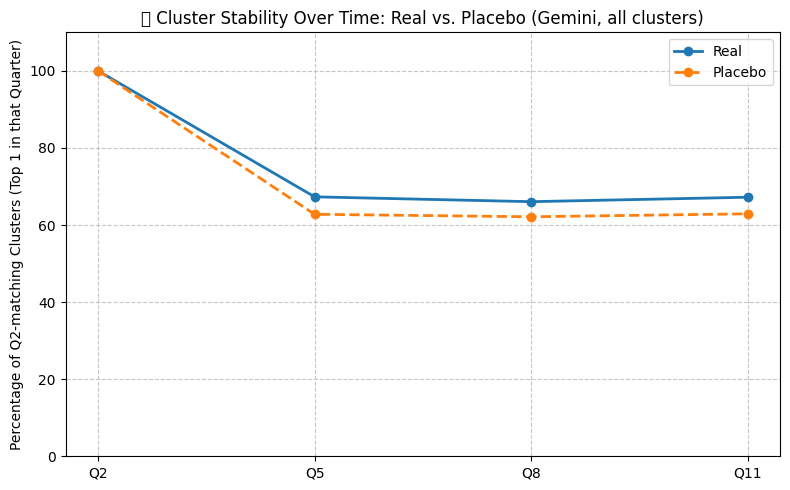

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load both datasets ===
df_real = pd.read_csv("../datasets/clustered_quarterly_metrics_gemini.csv")
df_placebo = pd.read_csv("../datasets/clustered_quarterly_metrics_placebo_gemini.csv")

def compute_stability_line(df, label):
    # Step 1: Get baseline CAIDs and their Q2 cluster
    baseline = df[(df["quarter"] == 2) & (df["is_main_address_gemini_top5"] == 1)]
    q2_clusters = baseline[["caid", "cluster"]].rename(columns={"cluster": "q2_cluster"})

    # Step 2: Merge Q2 cluster into full dataframe
    df = df.merge(q2_clusters, on="caid", how="inner")

    # Step 3: Compare Q2 cluster with each quarter's selected cluster
    stability_by_quarter = []
    for q in [2, 5, 8, 11]:
        temp = df[(df["quarter"] == q) & (df["is_main_address_gemini_top5"] == 1)].copy()
        temp["match_q2"] = temp["cluster"] == temp["q2_cluster"]
        pct_match = temp["match_q2"].mean() * 100
        stability_by_quarter.append(pct_match)

    return stability_by_quarter, label

# === Compute lines ===
real_values, real_label = compute_stability_line(df_real, "Real")
placebo_values, placebo_label = compute_stability_line(df_placebo, "Placebo")

# === Plot ===
quarters = ["Q2", "Q5", "Q8", "Q11"]

plt.figure(figsize=(8, 5))
plt.plot(quarters, real_values, marker='o', linewidth=2, label=real_label)
plt.plot(quarters, placebo_values, marker='o', linewidth=2, linestyle='--', label=placebo_label)
plt.ylim(0, 110)
plt.ylabel("Percentage of Q2-matching Clusters (Top 1 in that Quarter)")
plt.title("🏠 Cluster Stability Over Time: Real vs. Placebo (Gemini, all clusters)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()



In [32]:
df_real.head()

,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,log_total_pings,total_full_days_in_quarter,consistency_score,total_days_in_quarter,cluster_day_days,day_consistency_score,total_evenings_in_quarter,cluster_evening_days,evening_consistency_score,total_nights_in_quarter,cluster_night_days,night_consistency_score,time_window_coverage,total_weekend_days,total_weekday_days,weekend_days,weekday_days,weekend_focus_score,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023,matches_known_address,matched_address,is_main_address_gemini_top5,main_address_justification_gemini_top5
0,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,0,32,3,3,90020,34.065744,-118.296350,3.496508,4,0.750000,2.0,2.0,1.0,2.0,1.0,0.5,NaN,0.0,NaN,0.666667,1.0,3.0,NaN,3.0,NaN,0.666667,0.900256,253,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9...",1,Cluster 0 is the most likely home address beca...
1,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,1,9,1,1,90002,33.959281,-118.253437,2.302585,4,0.250000,2.0,0.0,0.0,2.0,1.0,0.5,NaN,0.0,NaN,0.333333,1.0,3.0,1.0,NaN,NaN,0.187500,NaN,1,56158,0,NaN,0,NaN
2,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,2,7,1,1,91606,34.182663,-118.383647,2.079442,4,0.250000,2.0,0.0,0.0,2.0,1.0,0.5,NaN,0.0,NaN,0.333333,1.0,3.0,NaN,1.0,NaN,0.145833,NaN,1,66884,0,NaN,0,NaN
3,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,0,106,2,12,90020,34.065744,-118.296350,4.672829,3,0.666667,2.0,2.0,1.0,NaN,0.0,NaN,3.0,2.0,0.666667,0.666667,NaN,3.0,NaN,2.0,NaN,0.946429,2.257982,87,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9...",1,Cluster 0 is the better choice for the main ho...
4,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,3,6,1,2,90020,34.065623,-118.292500,1.945910,3,0.333333,2.0,0.0,0.0,NaN,0.0,NaN,3.0,1.0,0.333333,0.333333,NaN,3.0,NaN,1.0,NaN,0.053571,0.450561,4,55832,0,NaN,0,NaN


# Predict placebo data with 4o-mini

In [70]:
cluster_quarterly_metrics_placebo = pd.read_csv("../datasets/cluster_quarterly_metrics_placebo.csv")

In [71]:
import pandas as pd


filtered_data = (
    cluster_quarterly_metrics_placebo
    .sort_values(['caid', 'quarter', 'total_pings'], ascending=[True, True, False])
    .groupby(['caid', 'quarter'])
    .head(5)
    .copy()
)

filtered_data.shape

(158583, 31)

In [ ]:
import pandas as pd
import os
from dotenv import load_dotenv
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field, ValidationError

# Load API key
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


model = ChatOpenAI(
    model_name="gpt-4o-mini",  # or "gpt-4o-mini" if officially supported
    temperature=0.0,
    api_key=""
)

# ----------------------------
# Define output schema
# ----------------------------
class MainClusterSelection(BaseModel):
    main_cluster: int = Field(description="Cluster number selected as main address")
    justification: str = Field(description="Why this cluster was selected")

parser = PydanticOutputParser(pydantic_object=MainClusterSelection)

# ----------------------------
# Prompt template
# ----------------------------
prompt = PromptTemplate(
    template="""
Each user (identified by a CAID) has multiple location clusters detected from mobile signals. Each cluster represents a place where the user spent time during the quarter.

Your task is to select the **main home address cluster** for the user based on the features below. We would like to differentiate from all other addresses, especially from work address.

A main address is usually:
- High **night** or **evening** consistency scores
- High consistency score
- High unique hours, meaning that the user is active at different times of the day
- High max consecutive hours, meaning that the user is active for a long time. 
- Long stays and broad time window coverage
- High dominance score
- High total pings and diverse hourly activity (entropy)

### Column Descriptions

cluster: Cluster index for this user 
consistency_score : % of days (from midnight to midnight) this cluster was seen
night_consistency_score: % of nights this cluster was seen (NaN if no night pings for the device during that quarter)  
evening_consistency_score: % of evenings this cluster was seen (NaN if no evening pings for the device during that quarter)  
day_consistency_score: % of daytime days (between 8am and 8pm)  this cluster was seen (NaN if no day pings for the device during that quarter)  
dominance_score: % of device pings in this cluster  
total_pings: Total number of pings in this cluster  
unique_hours: Number of unique hourly bins this cluster was active  
hour_entropy: Entropy of hourly activity (NaN if too few pings)  
max_consecutive_hours: It is the longest streak of consecutive hourly timestamps where a device was active only in one cluster, ignoring hours with no pings (silent hours).
time_window_coverage: Fraction of [day, evening, night] time windows with activity

---

### Cluster Candidates

{cluster_table}

Choose the main_cluster and explain why.

{format_instructions}
""",
    input_variables=["cluster_table"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

chain = prompt | model | parser

# ----------------------------
# Format one CAID’s cluster group
# ----------------------------
def format_cluster_group(group):
    return "\n".join([
        f"cluster: {row['cluster']}, "
        f"consistency_score: {row['consistency_score']}, "
        f"night_consistency_score: {row['night_consistency_score']}, "
        f"evening_consistency_score: {row['evening_consistency_score']}, "
        f"day_consistency_score: {row['day_consistency_score']}, "
        f"dominance_score: {row['dominance_score']}, "
        f"total_pings: {row['total_pings']}, "
        f"unique_hours: {row['unique_hours']}, "
        f"hour_entropy: {row['hour_entropy']}, "
        f"max_consecutive_hours: {row['max_consecutive_hours']}, "
        f"time_window_coverage: {row['time_window_coverage']}"
        for _, row in group.iterrows()
    ])

# ----------------------------
# LLM call for one user
# ----------------------------
def decide_main_cluster(caid, group):
    try:
        table = format_cluster_group(group)
        output = chain.invoke({"cluster_table": table})
        return {
            "caid": caid,
            "quarter": group.iloc[0]["quarter"],
            "cluster": output.main_cluster,
            "is_main_address_4o_top5": 1,
            "main_address_justification_4o_top5": output.justification
        }
    except Exception as e:
        print(f"❌ Error for caid {caid}: {e}")
        return None

# ----------------------------
# Threaded 4o call for each CAID
# ----------------------------
results = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {
        executor.submit(decide_main_cluster, caid, group): caid
        for (caid, quarter), group in filtered_data.groupby(["caid", "quarter"])
    }
    for future in tqdm(as_completed(futures), total=len(futures), desc="4p (Top 5)"):
        result = future.result()
        if result:
            results.append(result)

# ----------------------------
# Merge results and save
# ----------------------------
df_results = pd.DataFrame(results)
df = filtered_data.merge(df_results, on=["caid", "quarter", "cluster"], how="left")

df["is_main_address_4omini_top5"] = df["is_main_address_4o_top5"].fillna(0).astype(int)
df["main_address_justification_4omini_top5"] = df["main_address_justification_4o_top5"].fillna("")

df.to_csv("../datasets/filtered_data_with_main_address_per_user_4omini_placebo_all.csv", index=False)
print("✅ Done. 4o predictions for top 5 clusters per CAID saved.")

4p (Top 5): 100%|██████████| 37991/37991 [3:16:43<00:00,  3.22it/s]  


✅ Done. 4o predictions for top 5 clusters per CAID saved.


# Histogram of difference for real vs placebo

## Gemini

### Filter real data that have a matched address. Filter the same number of placebo caids. Then make histograms with these 2 new filtered datasets.

Number of unique real CAIDs (Q2 & matches_known_address == 1): 6461


/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_60821/771897214.py:51: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/othmanbensouda/Desktop/mobile_data/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


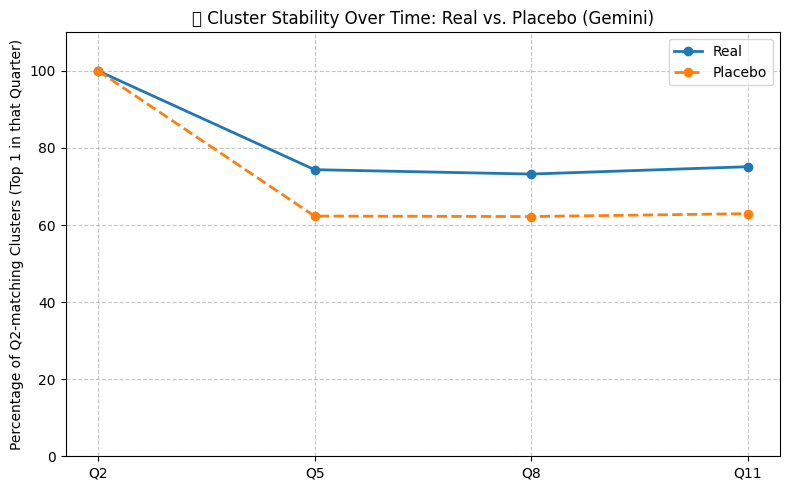

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Load both datasets ===
df_real = pd.read_csv("../datasets/clustered_quarterly_metrics_gemini.csv")
df_placebo = pd.read_csv("../datasets/clustered_quarterly_metrics_placebo_gemini.csv")

# === Step 1: Select CAIDs from df_real where matched_address == 1 in Q2 ===
baseline_real_caids = df_real[(df_real["quarter"] == 2) & (df_real["matches_known_address"] == 1) & (df_real["is_main_address_gemini_top5"] == 1)]["caid"].unique()
print(f"Number of unique real CAIDs (Q2 & matches_known_address == 1): {len(baseline_real_caids)}")

# === Step 2: Keep all quarters but only those CAIDs in df_real ===
df_real_filtered = df_real[df_real["caid"].isin(baseline_real_caids)]

# === Step 3: Randomly sample the same number of CAIDs in df_placebo ===
np.random.seed(42)
baseline_placebo_caids = np.random.choice(df_placebo["caid"].unique(), size=len(baseline_real_caids), replace=False)
df_placebo_filtered = df_placebo[df_placebo["caid"].isin(baseline_placebo_caids)]

# === Stability function ===
def compute_stability_line(df, label):
    baseline = df[(df["quarter"] == 2) & (df["is_main_address_gemini_top5"] == 1)]
    q2_clusters = baseline[["caid", "cluster"]].rename(columns={"cluster": "q2_cluster"})
    df = df.merge(q2_clusters, on="caid", how="inner")

    stability_by_quarter = []
    for q in [2, 5, 8, 11]:
        temp = df[(df["quarter"] == q) & (df["is_main_address_gemini_top5"] == 1)].copy()
        temp["match_q2"] = temp["cluster"] == temp["q2_cluster"]
        pct_match = temp["match_q2"].mean() * 100
        stability_by_quarter.append(pct_match)

    return stability_by_quarter, label

# === Compute lines ===
real_values, real_label = compute_stability_line(df_real_filtered, "Real")
placebo_values, placebo_label = compute_stability_line(df_placebo_filtered, "Placebo")

# === Plot ===
quarters = ["Q2", "Q5", "Q8", "Q11"]

plt.figure(figsize=(8, 5))
plt.plot(quarters, real_values, marker='o', linewidth=2, label=real_label)
plt.plot(quarters, placebo_values, marker='o', linewidth=2, linestyle='--', label=placebo_label)
plt.ylim(0, 110)
plt.ylabel("Percentage of Q2-matching Clusters (Top 1 in that Quarter)")
plt.title("🏠 Cluster Stability Over Time: Real vs. Placebo (Gemini)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# 4o-mini

In [62]:
df_real = pd.read_csv("../datasets/filtered_data_with_main_address_per_user_4omini_all.csv")


Number of unique real CAIDs (Q2 & matches_known_address == 1): 6513


/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_60821/3372290625.py:51: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/othmanbensouda/Desktop/mobile_data/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


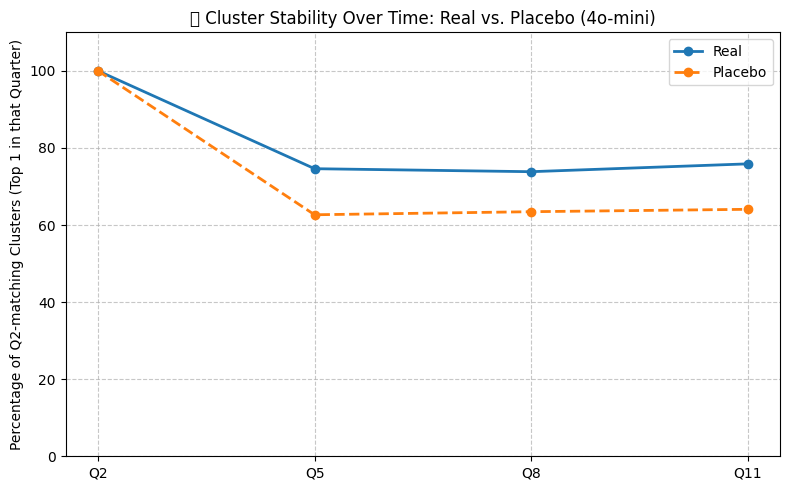

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Load both datasets ===
df_real = pd.read_csv("../datasets/filtered_data_with_main_address_per_user_4omini_all.csv")
df_placebo = pd.read_csv("../datasets/filtered_data_with_main_address_per_user_4omini_placebo_all.csv")

# === Step 1: Select CAIDs from df_real where matched_address == 1 in Q2 ===
baseline_real_caids = df_real[(df_real["quarter"] == 2) & (df_real["matches_known_address"] == 1) & (df_real["is_main_address_4omini_top5"] == 1)]["caid"].unique()
print(f"Number of unique real CAIDs (Q2 & matches_known_address == 1): {len(baseline_real_caids)}")

# === Step 2: Keep all quarters but only those CAIDs in df_real ===
df_real_filtered = df_real[df_real["caid"].isin(baseline_real_caids)]

# === Step 3: Randomly sample the same number of CAIDs in df_placebo ===
np.random.seed(42)
baseline_placebo_caids = np.random.choice(df_placebo["caid"].unique(), size=len(baseline_real_caids), replace=False)
df_placebo_filtered = df_placebo[df_placebo["caid"].isin(baseline_placebo_caids)]

# === Stability function ===
def compute_stability_line(df, label):
    baseline = df[(df["quarter"] == 2) & (df["is_main_address_4omini_top5"] == 1)]
    q2_clusters = baseline[["caid", "cluster"]].rename(columns={"cluster": "q2_cluster"})
    df = df.merge(q2_clusters, on="caid", how="inner")

    stability_by_quarter = []
    for q in [2, 5, 8, 11]:
        temp = df[(df["quarter"] == q) & (df["is_main_address_4omini_top5"] == 1)].copy()
        temp["match_q2"] = temp["cluster"] == temp["q2_cluster"]
        pct_match = temp["match_q2"].mean() * 100
        stability_by_quarter.append(pct_match)

    return stability_by_quarter, label

# === Compute lines ===
real_values, real_label = compute_stability_line(df_real_filtered, "Real")
placebo_values, placebo_label = compute_stability_line(df_placebo_filtered, "Placebo")

# === Plot ===
quarters = ["Q2", "Q5", "Q8", "Q11"]

plt.figure(figsize=(8, 5))
plt.plot(quarters, real_values, marker='o', linewidth=2, label=real_label)
plt.plot(quarters, placebo_values, marker='o', linewidth=2, linestyle='--', label=placebo_label)
plt.ylim(0, 110)
plt.ylabel("Percentage of Q2-matching Clusters (Top 1 in that Quarter)")
plt.title("🏠 Cluster Stability Over Time: Real vs. Placebo (4o-mini)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# All clusters, 4o-mini

/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_60821/3392746330.py:41: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/othmanbensouda/Desktop/mobile_data/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


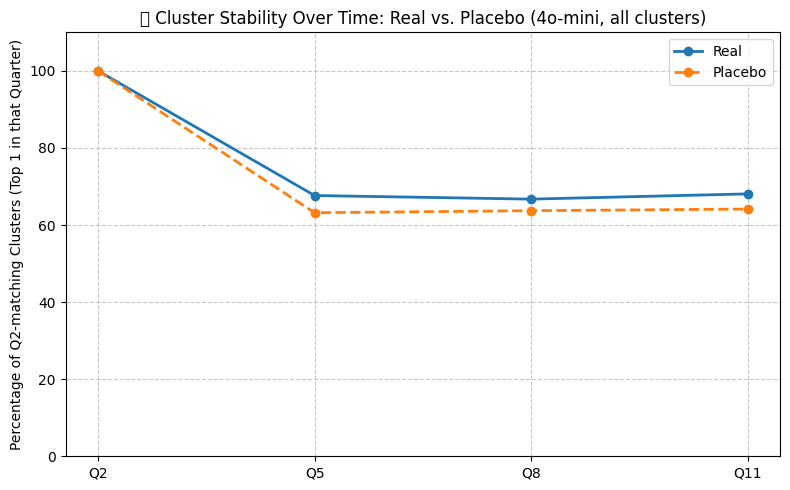

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load both datasets ===
df_real = pd.read_csv("../datasets/filtered_data_with_main_address_per_user_4omini_all.csv")
df_placebo = pd.read_csv("../datasets/filtered_data_with_main_address_per_user_4omini_placebo_all.csv")

def compute_stability_line(df, label):
    # Step 1: Get baseline CAIDs and their Q2 cluster
    baseline = df[(df["quarter"] == 2) & (df["is_main_address_4omini_top5"] == 1)]
    q2_clusters = baseline[["caid", "cluster"]].rename(columns={"cluster": "q2_cluster"})

    # Step 2: Merge Q2 cluster into full dataframe
    df = df.merge(q2_clusters, on="caid", how="inner")

    # Step 3: Compare Q2 cluster with each quarter's selected cluster
    stability_by_quarter = []
    for q in [2, 5, 8, 11]:
        temp = df[(df["quarter"] == q) & (df["is_main_address_4omini_top5"] == 1)].copy()
        temp["match_q2"] = temp["cluster"] == temp["q2_cluster"]
        pct_match = temp["match_q2"].mean() * 100
        stability_by_quarter.append(pct_match)

    return stability_by_quarter, label

# === Compute lines ===
real_values, real_label = compute_stability_line(df_real, "Real")
placebo_values, placebo_label = compute_stability_line(df_placebo, "Placebo")

# === Plot ===
quarters = ["Q2", "Q5", "Q8", "Q11"]

plt.figure(figsize=(8, 5))
plt.plot(quarters, real_values, marker='o', linewidth=2, label=real_label)
plt.plot(quarters, placebo_values, marker='o', linewidth=2, linestyle='--', label=placebo_label)
plt.ylim(0, 110)
plt.ylabel("Percentage of Q2-matching Clusters (Top 1 in that Quarter)")
plt.title("🏠 Cluster Stability Over Time: Real vs. Placebo (4o-mini, all clusters)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# 